# Dependencies

In [1]:
import pandas as pd
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

plt.style.use('fivethirtyeight')
%matplotlib inline

# Loading Datasets

In [2]:
# Replace with your csv file name
def load_data(file_name = None, file_loc = None, skiprows = None):   
    data = file_loc if file_loc is not None else os.path.join(f'{file_name}.csv')
    return pd.read_csv(data, skiprows=skiprows)

In [3]:
df_train = load_data('TrainData_A') #write only the name of the file without the extension
df_train.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 00:00,NaN,NaN,NaN,NaN,NaN
1,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492


We can see that the first row does not have any predicted value, so we can simply delete it. We can also skip this row while loading the dataset. 

# Exploratory Data Analysis

## Data Cleaning

In [4]:
df_train.drop(0, axis = 0, inplace = True)
df_train.reset_index(drop=True, inplace=True)
df_train.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
1,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27048 entries, 0 to 27047
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TIMESTAMP  27048 non-null  object 
 1   POWER      26590 non-null  float64
 2   U10        27048 non-null  float64
 3   V10        27048 non-null  float64
 4   U100       27048 non-null  float64
 5   V100       27048 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


The information above shows that we have some null values in power column (target variable). Let us dig a little deeper in this column and come up with a way to tackle this issue. All columns except for timestamp column are numerical (float64). It is better to convert the timestamp column from object type to datetime object.

In [6]:
df_train.isnull().sum()

TIMESTAMP      0
POWER        458
U10            0
V10            0
U100           0
V100           0
dtype: int64

There are a total of 458 missing values in our dataset and to fill these missing values we have three options.

1. `Persistence:` We will see later that there exist some kind of correlation between the power produced at time t and the power produced one hour ago (t-1). Therefore, it is an appropriate assumption to the fill the value with the value from the previous hour.

2. `Rolling Mean:` It is also a nice strategy to take a mean over the last few hours.

In [7]:
def fill_values(df_orig, strategy = 'persistence'):
    df = df_orig.copy()
    if strategy == 'persistence':
        df['POWER'] = df['POWER'].ffill()
        df['POWER'] = df['POWER'].bfill()

    else:
        iteration, max_iterations = 0, 50
        while iteration < max_iterations:
            missing = df.POWER.isnull().sum()
            df['POWER']= df['POWER'].fillna(df['POWER'].rolling(3,min_periods=1,center=True).mean())
            missing_update = df.POWER.isnull().sum()
            if missing_update < missing:
                iteration +=1
            elif missing_update == 0:
                break
    return df

### Comparison of Strategies

In [8]:
# mean power without filling nan values
mean_wo_fill = df_train.POWER.mean()

# mean power after filling nan values with persistence strategy 
df_pers = fill_values(df_train, 'persistence')
mean_pers = df_pers.POWER.mean()

# mean power after filling nan values with persistence strategy
df_rm = fill_values(df_train, 'rm')
mean_rm = df_rm.POWER.mean()

print(f'The mean value of power;\nWithout filling nan values: {mean_wo_fill}\nPersistence Strategy: {mean_pers}\
            \nRolling Mean Strategy: {mean_rm}')


The mean value of power;
Without filling nan values: 0.5196765502417882
Persistence Strategy: 0.5193068332677784            
Rolling Mean Strategy: 0.5184336397289607


In [9]:
df_train = fill_values(df_train, 'persistence')
df_train.isnull().sum()

TIMESTAMP    0
POWER        0
U10          0
V10          0
U100         0
V100         0
dtype: int64

The mean after filling the nan values using persistence strategy is closer to the actual mean without any filling so we used persistence technique for filling the nan values in power column.

In [10]:
df_train.duplicated().sum()

0

The dataset is clean now as we no longer have any missing values in our dataset and also there was not any duplicate row detected. We can now proceed with the data manipulation step.

## Data Manipulation

In [11]:
df_train.describe()

,POWER,U10,V10,U100,V100
count,27048.000000,27048.000000,27048.000000,27048.000000,27048.000000
mean,0.519307,2.286938,0.700514,3.124931,1.051055
std,0.312984,5.100936,4.481148,7.018101,6.150222
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400
25%,0.230142,-1.747315,-2.539780,-2.175257,-3.433463
50%,0.542578,2.788535,0.745344,3.923615,1.024665
75%,0.811039,6.047033,3.814063,8.239865,5.320432
max,1.000000,21.876300,18.122800,31.050900,25.117400


In [12]:
df_train.iloc[:,1:].corr()['POWER']

POWER    1.000000
U10      0.484248
V10      0.135791
U100     0.482299
V100     0.134175
Name: POWER, dtype: float64

Right now, we are unable to deduce any meaningful conclusion from the dataset as we are not used to dealing with `u` and `v` components of wind. So to give our data some meaning we can covert the components into wind magnitude and wind direction.\
Also it can be seen that there exist some correlation between the existing features and the target variable however, they are not good enough to put into a model and expect good predictions. So now we are creating more features from the existing ones.

In [13]:
# Wind Magnitude from the u and v component of the wind
def wind_mag(u,v):
    return np.sqrt(u**2+v**2)


# Wind Direction from the u and v component of the wind
def wind_dir(v,u):
    # gives the angle in degrees
    return np.degrees(np.arctan2(v, u)) 

'''
alpha is used in power law calculations which is used to extrapolate the speed of wind to higher altitudes. The value of
alpha gives the information about surface roughness. It has different values for onshore and offshore. For offshore(our case)
the value is usually 0.11. However, the results from this constant value might be erroneous. As there are a lot of factors that
affect its value.
'''
def calc_alpha(ws_100,ws_10):
    num = np.log(ws_100/ws_10)
    denom = np.log(100/10)
    if ws_100 > ws_10: # otherwise the exponent would be negative which does not make sense
        a_val = num/denom
    else:
         a_val = 0.11
    return a_val

def pow_law(ws_10,e_h, h=50, strategy = 'const'):
    if strategy == 'const':
        alpha = 0.11
    else:
        alpha = e_h
    return ws_10 * ((h/10)**alpha)

In [87]:
df = df_train.copy()
# df.head()

`Vmag10:`&nbsp; &nbsp;Magnitude of wind at 10m height\
`Vmag100:`&nbsp;Magnitude of wind at 100m height\
`Vdir10:`&nbsp; &nbsp;Wind direction at 10m height\
`Vdir100:`&nbsp;Wind direction at 100m height\
`alpha:`&nbsp; &nbsp; &nbsp;Cosntant for Surface roughness\
`Vmag50_const:`Magnitude of wind calculated from hellman's formula at 50m height using a constant value of alpha (0.11)\
`Vmag50_var:`&nbsp; &nbsp; Magnitude of wind calculated from hellman's formula at 50m height using alpha calculated from a formula using the wind speed at that height. Further details are mentioned in the report.

In [88]:
df['Vmag10'] = np.vectorize(wind_mag)(df['V10'], df['U10'])
df['Vmag100'] = np.vectorize(wind_mag)(df['V100'], df['U100'])
df['Vdir10'] = np.vectorize(wind_dir)(df['V10'], df['U10'])
df['Vdir100'] = np.vectorize(wind_dir)(df['V100'], df['U100'])
df['alpha'] = np.vectorize(calc_alpha)(df['Vmag100'], df['Vmag10'])
df['Vmag50_const'] = np.vectorize(pow_law)(df['Vmag10'],df['alpha'],50,strategy = 'const')
df['Vmag50_var'] = np.vectorize(pow_law)(df['Vmag10'],df['alpha'],50,strategy = 'var')

In [89]:
const_strat = df['Vmag50_const'].mean()
var_strat = df['Vmag50_var'].mean()

print(f'The mean value of wind speed using constant strategy: {const_strat}\
\nThe mean value of wind speed using var strategy: {var_strat}')

The mean value of wind speed using constant strategy: 7.823133234032567
The mean value of wind speed using var strategy: 8.186204497184441


In [90]:
df.iloc[:,1:].corr()['POWER']

POWER           1.000000
U10             0.484248
V10             0.135791
U100            0.482299
V100            0.134175
Vmag10          0.858020
Vmag100         0.846472
Vdir10          0.092538
Vdir100         0.080657
alpha          -0.052066
Vmag50_const    0.858020
Vmag50_var      0.853922
Name: POWER, dtype: float64

We can see that the wind speed calculated using the constant strategy has a better correlation coefficient. Therefore, we will us this strategy for creating extrapolating wind speeds at different heights.

In [91]:
df[['Vmag10','Vmag100']].describe()

,Vmag10,Vmag100
count,27048.000000,27048.000000
mean,6.553813,9.012948
std,2.977785,4.088160
min,0.025588,0.036808
25%,4.371349,6.096209
50%,6.306807,8.680288
75%,8.456248,11.541705
max,22.269912,31.450741


The table above gives a better idea of the distribution of wind speed at two different heights. The mean wind speed are also very close to the mean wind speed, at this location, given by [Global Wind Atlas](https://globalwindatlas.info/en/area/Denmark/Midtjylland)

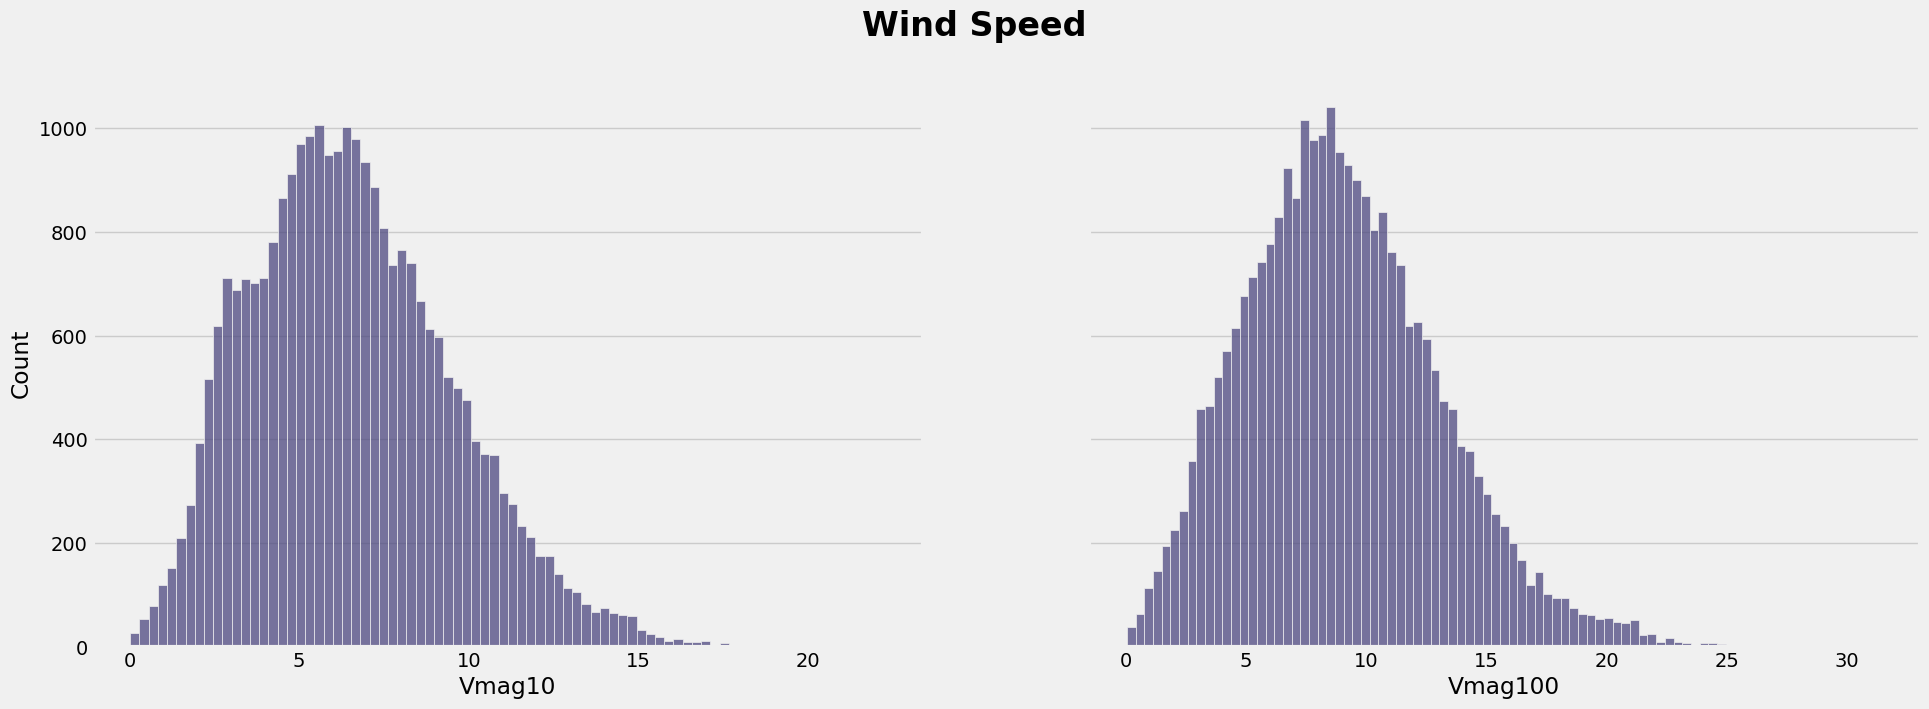

In [109]:
fig, axes = plt.subplots(1,2, sharey=True)
sns.histplot(df['Vmag10'],ax = axes[0], color = '#4D4880')
sns.histplot(df['Vmag100'],ax = axes[1], color = '#4D4880')
axes[0].grid(False, axis= 'x')
axes[1].grid(False, axis= 'x')
fig.suptitle('Wind Speed',fontsize=24, fontweight ='bold')
plt.savefig('wind_speed_histograms.png', bbox_inches= 'tight');

As the mdoel that we intend to use for this project is senstive to the outliers so with the help of these histograms we will figure out a way to remove outliers from our data.
We can use two strategies;\
1. Remove the rows that have the wind speeds greater than 99 percentile or less than 1 perctile.
2. Replace the outliers with the value of 1st and 99th percentile.

In [110]:
V10_q_1 = np.quantile(df['Vmag10'],0.01)
V100_q_1 = np.quantile(df['Vmag100'],0.01)
V10_q_99 = np.quantile(df['Vmag10'],0.99)
V100_q_99 = np.quantile(df['Vmag100'],0.99)

print(f'The first and 99th quantile at 10m height are {round(V10_q_1,2)}m/s and {round(V10_q_99,2)}m/s')
print(f'The first and 99th quantile at 100m height are {round(V100_q_1,2)}m/s and {round(V100_q_99,2)}m/s')

The first and 99th quantile at 10m height are 1.1m/s and 14.45m/s
The first and 99th quantile at 100m height are 1.26m/s and 20.25m/s


In [111]:
df[(df['Vmag100']>20.25)|(df['Vmag10']>14.45)].count()[0]

321

In [112]:
df[(df['Vmag100']<1.26)|(df['Vmag10']<1.099)].count()[0]

342

In [113]:
def handle_outliers(df_orig, cols, drop = True):
    df = df_orig.copy()
    V10, V100 = cols[0],cols[1]
    V10_q_1 = np.quantile(df[V10],0.01)
    V100_q_1 = np.quantile(df[V100],0.01)
    V10_q_99 = np.quantile(df[V10],0.99)
    V100_q_99 = np.quantile(df[V100],0.99)
    
    V10_lim = (df[V10]<V10_q_1)|(df[V10]>V10_q_99)
    V100_lim = (df[V100]<V100_q_1)|(df[V100]>V100_q_99)
    if drop:
        df = df[~(V10_lim | V100_lim)]
    else:
        for col in cols:
            low_lim = np.quantile(df[col],0.01)
            upp_lim = np.quantile(df[col],0.99)
            df[col] = df[col].apply(lambda x: low_lim if x < low_lim else x)
            df[col] = df[col].apply(lambda x: upp_lim if x > upp_lim else x)
    return df

In [114]:
df_drop = handle_outliers(df,cols = ['Vmag10','Vmag100'], drop = True)
df_rep = handle_outliers(df,cols = ['Vmag10','Vmag100'], drop = False)
# df_rep_100 = handle_outliers(df,False,'Vmag100')

drop_mean_10 = df_drop.Vmag10.mean()
drop_mean_100 = df_drop.Vmag100.mean()
rep_mean_10 = df_rep.Vmag10.mean()
rep_mean_100 = df_rep.Vmag100.mean()

print(f'The mean wind speed at 10m height with the two strategies is:\
        \n1. Dropping strategy: {drop_mean_10}\n2. Replacing strategy: {rep_mean_10}\n')


print(f'The mean wind speed at 100m height with the two strategies is:\
        \n1. Dropping strategy: {drop_mean_100}\n2. Replacing strategy: {rep_mean_100}')

The mean wind speed at 10m height with the two strategies is:        
1. Dropping strategy: 6.518568200373719
2. Replacing strategy: 6.544939279357997

The mean wind speed at 100m height with the two strategies is:        
1. Dropping strategy: 8.963444909434715
2. Replacing strategy: 9.000267191913425


In [115]:
df = handle_outliers(df,cols = ['Vmag10','Vmag100'], drop=False)

### Rolling Means and Autocorrelation

In [116]:
df['TIMESTAMP'] = pd.to_datetime(df.TIMESTAMP)
df['DATE'] = df['TIMESTAMP'].dt.date
df.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100,Vmag10,Vmag100,Vdir10,Vdir100,alpha,Vmag50_const,Vmag50_var,DATE
0,2015-01-01 01:00:00,0.666693,6.24102,3.49613,9.73707,4.78492,7.153548,10.849239,29.256924,26.170089,0.180878,8.539024,9.570831,2015-01-01
1,2015-01-01 02:00:00,0.666693,5.62234,4.06239,8.94497,5.71768,6.936405,10.616231,35.849781,32.586965,0.184836,8.279825,9.339620,2015-01-01


In [117]:
df1 = df.groupby('DATE')[['Vmag10','Vmag100','POWER']].mean()
df2= df.groupby(df['TIMESTAMP'].dt.strftime('%m %B'))[['Vmag10','Vmag100','POWER']].mean().sort_index()
df2.reset_index(inplace = True)
df3= df.groupby([df['TIMESTAMP'].dt.year,df['TIMESTAMP'].dt.strftime('%m %B')])[['Vmag10','Vmag100','POWER']].mean().sort_index()
df3.reset_index(level =1, inplace = True)

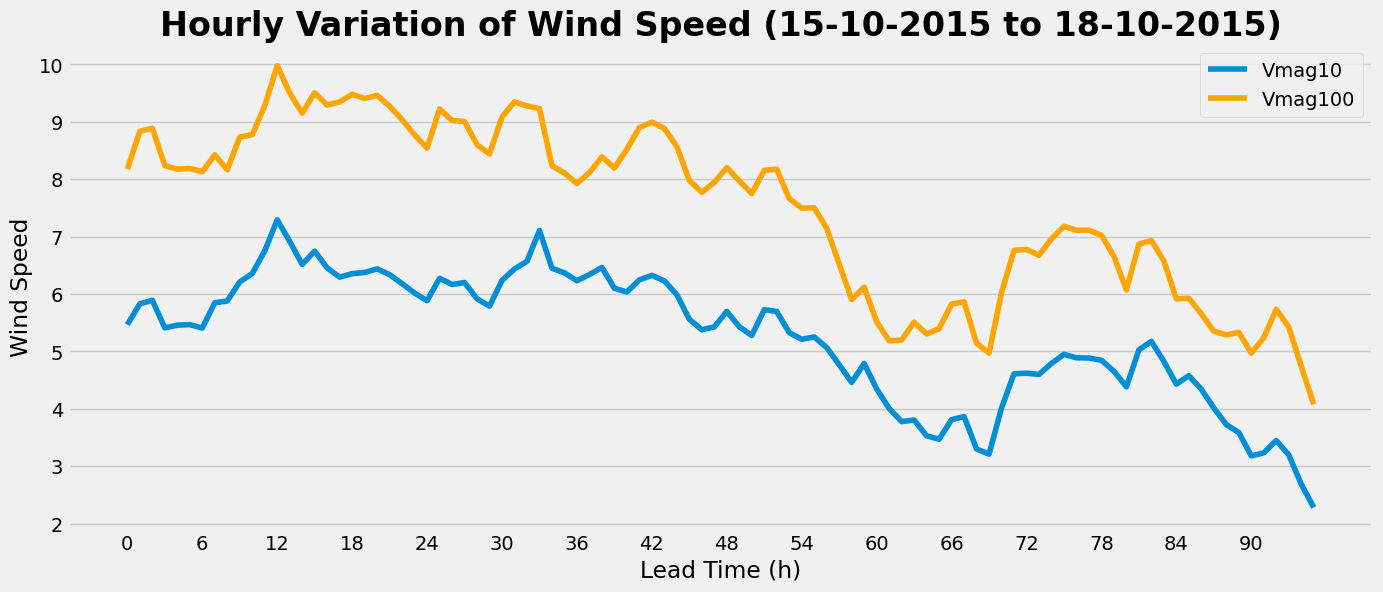

In [119]:
font =  {'fontsize': 24,'fontweight': 'bold'}

df_0 = df.copy()
df_0['DATE']=df_0['DATE'].astype('string')
filter = (df_0['DATE'] == '2015-10-15')|(df_0['DATE'] =='2015-10-16')|(df_0['DATE']=='2015-10-17')|(df_0['DATE']=='2015-10-18')
df_0 = df_0[filter]

x = np.arange(96)
y1 = df_0.Vmag10
y2 = df_0.Vmag100

plt.figure(figsize=(15,6))
sns.lineplot(x ='TIMESTAMP', y=y1, data = df_0, label ='Vmag10')
sns.lineplot(x ='TIMESTAMP', y=y2, data = df_0, label ='Vmag100', color = 'orange')
plt.title('Hourly Variation of Wind Speed (15-10-2015 to 18-10-2015)', fontdict=font)
plt.ylabel('Wind Speed')
plt.xlabel('Lead Time (h)')
plt.grid(visible = False, axis = 'x')
plt.xticks(df_0['TIMESTAMP'][:96], [i if i in range(0,97,6) else '' for i in range(96)])
plt.legend()
# plt.savefig('hourly_wind_variation.png',bbox_inches='tight');

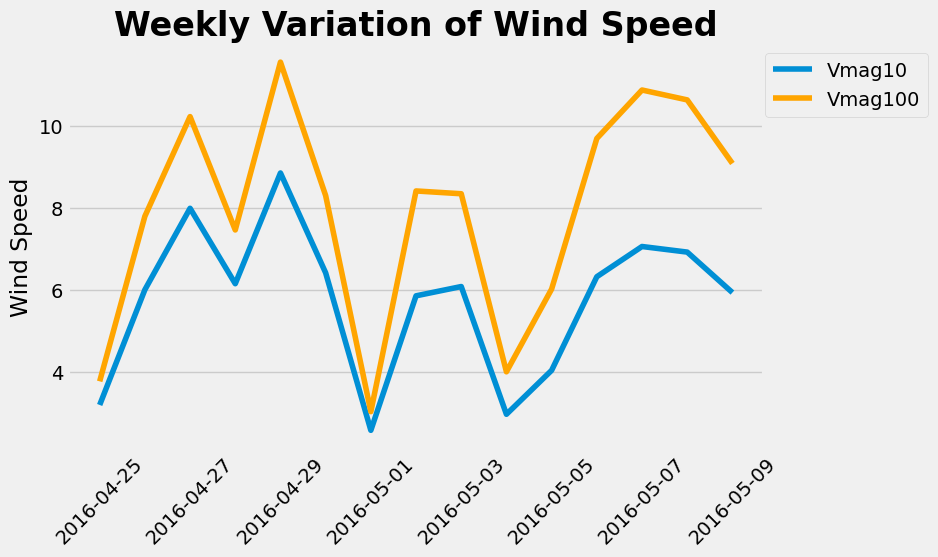

In [120]:
y1 = df1.Vmag10[480:495]
y2 = df1.Vmag100[480:495]
fig = plt.figure(figsize=(8,5))
sns.lineplot(x ='DATE', y=y1, data = df1, label ='Vmag10')
sns.lineplot(x ='DATE', y=y2, data = df1, label ='Vmag100', color = 'orange')
plt.title('Weekly Variation of Wind Speed', fontdict=font)
plt.ylabel('Wind Speed')
plt.xlabel('')
plt.grid(visible = False, axis = 'x')
plt.legend(bbox_to_anchor=(1.25,1))
plt.tick_params(axis = 'x', rotation = 45)
# plt.savefig('weekly_wind_variation.png',bbox_inches='tight');

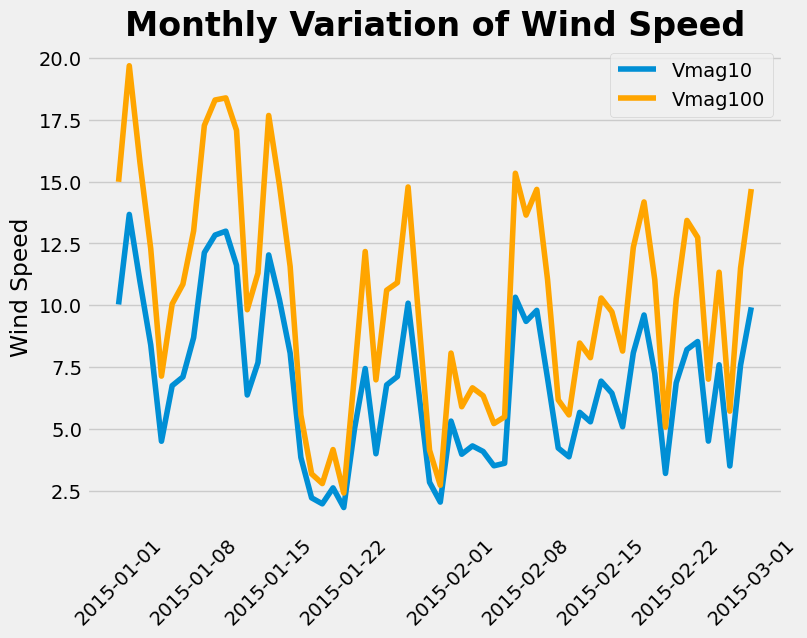

In [121]:
y1 = df1.Vmag10[:60]
y2 = df1.Vmag100[:60]
plt.figure(figsize=(8,6))
sns.lineplot(x ='DATE', y=y1, data = df1, label ='Vmag10')
sns.lineplot(x ='DATE', y=y2, data = df1, label ='Vmag100', color = 'orange')
plt.title('Monthly Variation of Wind Speed', fontdict=font)
plt.ylabel('Wind Speed')
plt.xlabel('')
plt.grid(visible = False, axis = 'x')
plt.legend()
plt.tick_params(axis = 'x', rotation = 45)
# plt.savefig('monthly_wind_variation.png',bbox_inches='tight');

From the graphs above, we can see that there exist some kind of hourly, weekly, and monthly pattern in the wind speed which is an indicator of seasonality. Also, as expected, the wind speed increases as we move to higher altitudes.

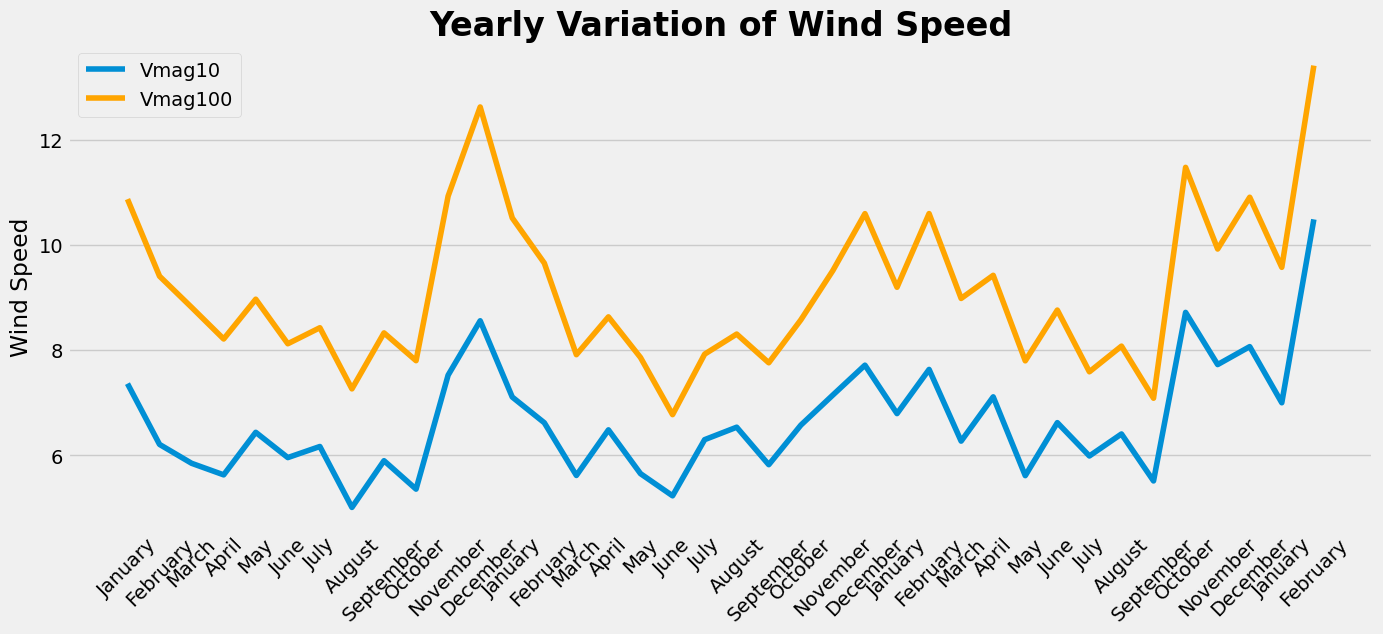

In [122]:
# pre-work for labels
dates = pd.date_range('2023-01-01', '2023-12-01', freq='MS')  # MS represents start of the month
months = dates.strftime('%B').tolist()
all_months = months*4
all_months = all_months[:38]

# setting x and y values
x = np.arange(38)
y3=df3.Vmag10
y4=df3.Vmag100

# plotting the graph
plt.figure(figsize=(15,6))
sns.lineplot(x=x,y= y3, data=df3, label = 'Vmag10')
sns.lineplot(x=x,y= y4, data=df3, label = 'Vmag100', color = 'orange')
plt.title('Yearly Variation of Wind Speed', fontdict=font)
plt.ylabel('Wind Speed')
plt.xticks(x,all_months)
plt.grid(visible =False, axis = 'x')
plt.tick_params(axis = 'x', rotation = 45)
# plt.savefig('yearly_wind_variation.png',bbox_inches='tight');

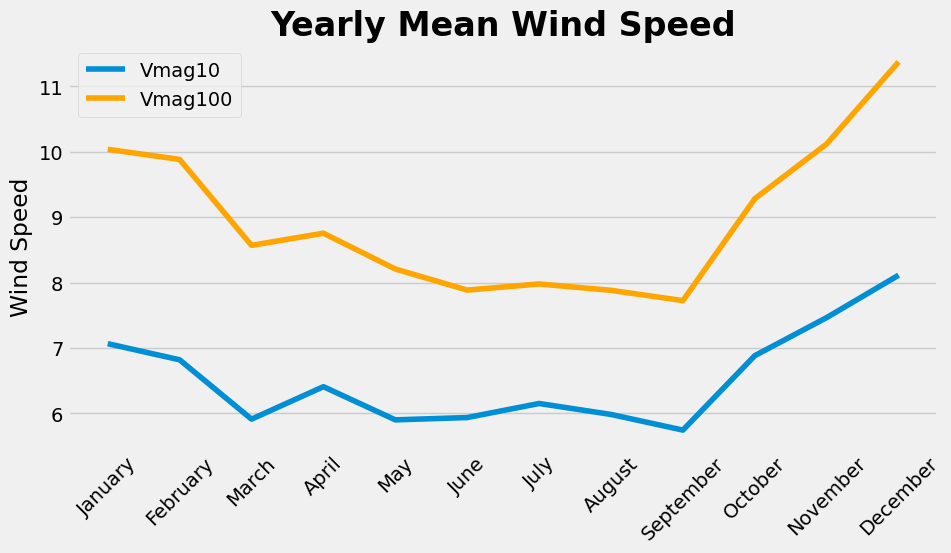

In [124]:
dates = pd.date_range('2023-01-01', '2023-12-01', freq='MS')  # MS represents start of the month
months = dates.strftime('%B').tolist()

y5=df2.Vmag10
y6=df2.Vmag100
plt.figure(figsize=(10,5))
sns.lineplot(x='TIMESTAMP',y= y5, data=df2, label = 'Vmag10')
sns.lineplot(x='TIMESTAMP',y= y6, data=df2, label = 'Vmag100', color = 'orange')
plt.xticks(df2['TIMESTAMP'], months)
plt.title('Yearly Mean Wind Speed', fontdict=font)
plt.ylabel('Wind Speed')
plt.xlabel('')
plt.grid(visible = False, axis = 'x')
plt.tick_params(axis = 'x', rotation = 45);

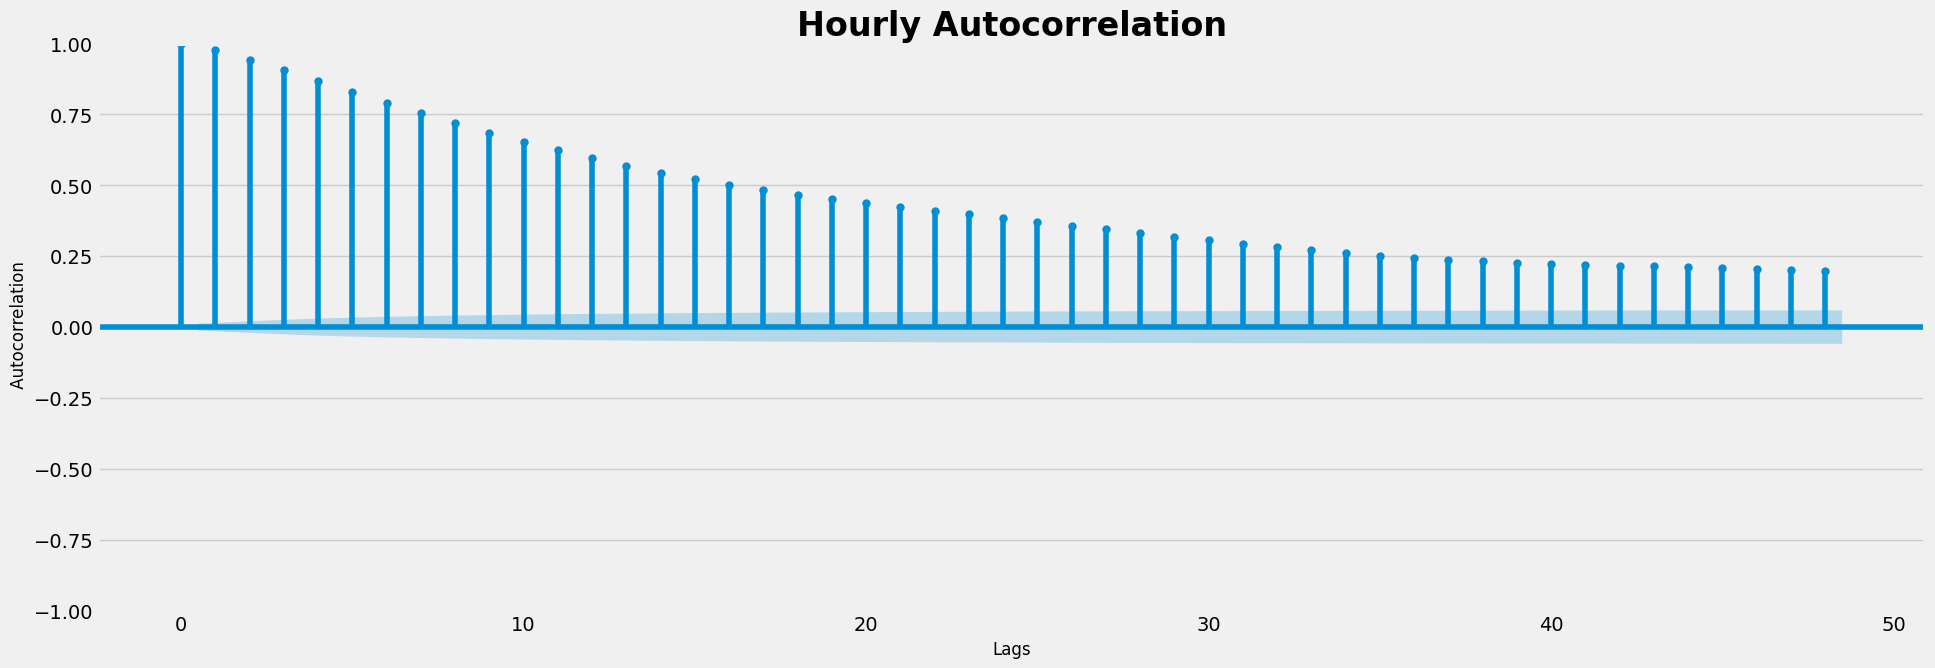

In [125]:
# fig, axes = plt.subplot()
from statsmodels.graphics.tsaplots import plot_acf
dataframe = df.set_index('TIMESTAMP')
plt.rc("figure", figsize=(21, 7))
plot_acf(dataframe.Vmag10, lags=24*2)
plt.title(f'Hourly Autocorrelation', fontdict=font)
plt.xlabel('Lags', fontsize=12)
plt.ylabel(' Autocorrelation', fontsize=12)
plt.grid(visible = False, axis = 'x')
# plt.savefig('hourly_autocorrelation.png',bbox_inches='tight');

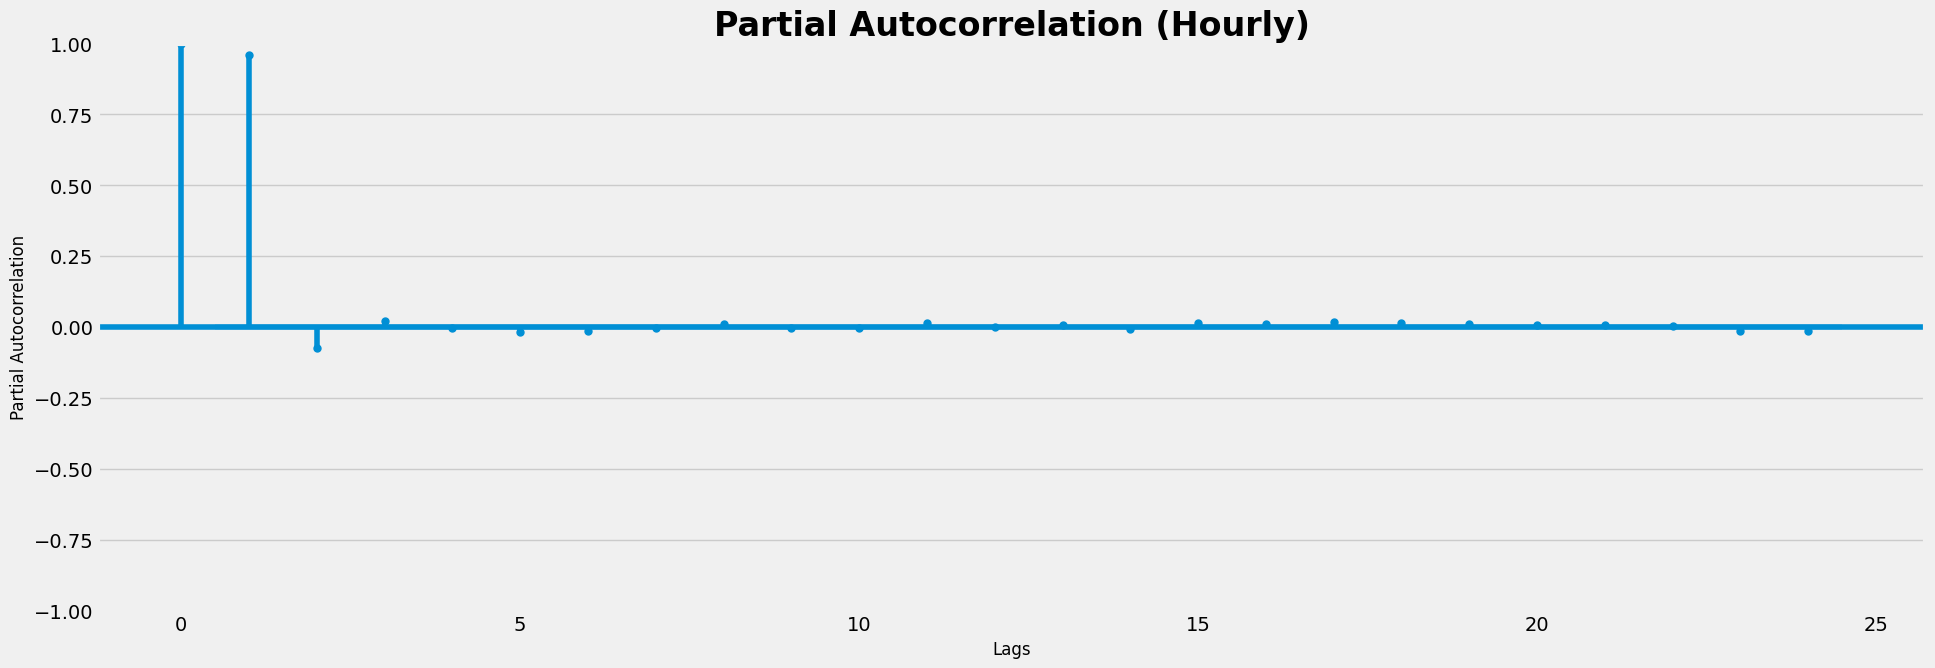

In [126]:
from statsmodels.graphics.tsaplots import plot_pacf
dataframe = df.set_index('TIMESTAMP')
# plt.rc("figure", figsize=(21, 7))
plot_pacf(dataframe.POWER, lags=24)
plt.xlabel('Lags', fontsize=12)
plt.title(f'Partial Autocorrelation (Hourly)', fontdict=font)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.grid(visible = False, axis = 'x')
# plt.savefig('hourly_autocorrelation_partial.png',bbox_inches='tight');

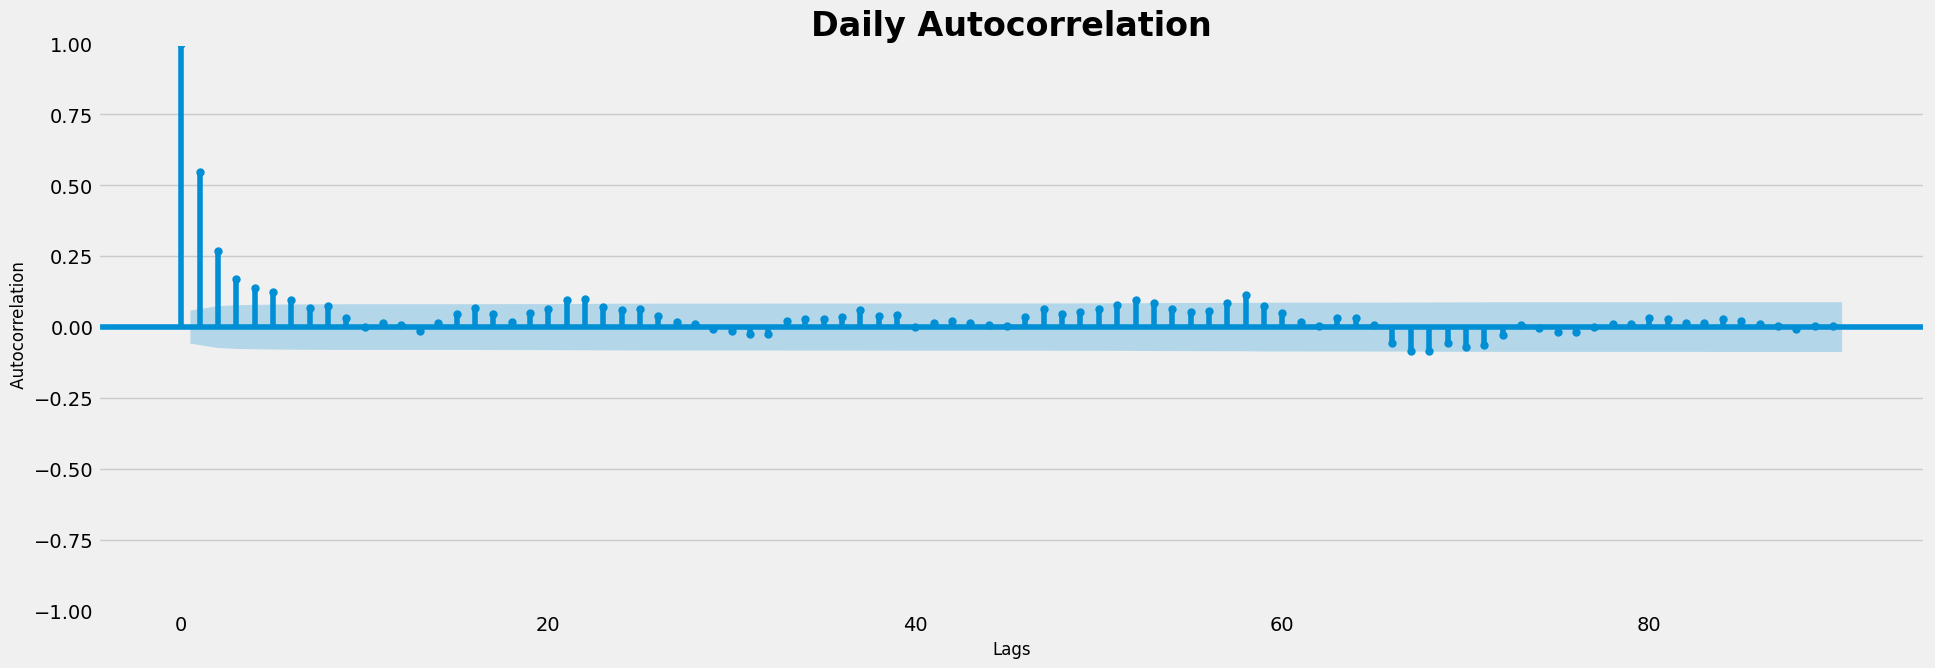

In [127]:
df_daily = df1.reset_index()
from statsmodels.graphics.tsaplots import plot_acf
dataframe = df_daily.set_index('DATE')
plt.rc("figure", figsize=(21, 7))
plot_acf(dataframe.Vmag10, lags=90)
plt.title(f'Daily Autocorrelation', fontdict=font)
plt.xlabel('Lags', fontsize=12)
plt.ylabel(' Autocorrelation', fontsize=12)
plt.grid(visible = False, axis = 'x')
# plt.savefig('daily_autocorrelation.png',bbox_inches='tight');

All these graphs indicate that there is a correlation between wind speed at different times which can be useful for us as we can create some rolling means

# Data Modelling

Now we will try to automate the work that has been done in the previous section.

In [45]:
df = load_data('TrainData_A', skiprows=[1])
df_t =df.copy()
df_t.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
1,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768
2,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
3,20150101 04:00,NaN,6.90809,4.79099,10.63280,6.75417
4,20150101 05:00,NaN,6.95268,4.83204,10.70080,6.74193


In [46]:
def add_cols(df): 
    # This function adds the extra features like wind speed and direction at different heights
    for hr in [0,3,5,7,11,13]:
        for i in [10,100]:
            df[f'Vmag{i}_ma_{hr}'] = np.vectorize(wind_mag)(df[f'V{i}_ma_{hr}'], df[f'U{i}_ma_{hr}'])
            df[f'Vdir{i}_ma_{hr}'] = np.vectorize(wind_dir)(df[f'V{i}_ma_{hr}'], df[f'U{i}_ma_{hr}'])
        
        df[f'alpha_ma_{hr}'] = np.vectorize(calc_alpha)(df[f'Vmag100_ma_{hr}'], df[f'Vmag10_ma_{hr}'])
        
        for j in [30,50,70]:
            df[f'Vmag{j}_ma_{hr}'] = np.vectorize(pow_law)(df[f'Vmag10_ma_{hr}'],df[f'alpha_ma_{hr}'],j,strategy = 'const')    

def moving_avg(df,col):
    '''This function calculates the moving averages of different wind speed and direction. The values that are 
    missing are filled with the values in the original column at the corrosponding hour'''
    
    for win in [3,5,7,11,13]:
        df[f'{col[:-1]}{win}'] = df[f'{col}'].rolling(win, center = True).mean()
        df[f'{col[:-1]}{win}'].fillna(df[f'{col}'],inplace = True)

def lag_features(df):
    '''This function calculates the lag in different wind speeds at different heights. As there exist a strong correlation
    in wind speed data, this feature will make our model more robust'''
    for vmag in [10,30,50,70,100]:
        for shift in [1,2,24,24*7,24*30]:
            df[f'Vmag{vmag}_lf_{shift}'] = df[f'Vmag{vmag}_ma_0'].shift(shift)
            df[f'Vmag{vmag}_lf_{shift}'].fillna(df[f'Vmag{vmag}_ma_0'], inplace = True)

def remove_feature(df_o,fe_nme):
    # This function removes the features that are not required for forecasting 
    df = df_o.copy()
    col_list = df.columns.to_list()
    new_col_list = []
    for element in col_list:
        if fe_nme not in element:
            new_col_list.append(element)
    return new_col_list

In [48]:
def pipeline_func(df, train = True, corr = False):
    df_proc = df.copy()
    if 'TIMESTAMP' in df_proc:
        df_proc.set_index('TIMESTAMP', inplace = True)
    if train:
       df_proc = fill_values(df_proc, strategy = 'persistence')
        
    col_dict = {'U10':'U10_ma_0','V10':'V10_ma_0','U100':'U100_ma_0','V100':'V100_ma_0'}
    df_proc.rename(columns = {
    'U10':'U10_ma_0','V10':'V10_ma_0',
    'U100':'U100_ma_0','V100':'V100_ma_0'}, inplace = True)
    
    for col in col_dict.values():
        moving_avg(df_proc,col)
        
    add_cols(df_proc)
    columns = [
        'Vmag10_ma_0','Vmag100_ma_0','Vmag10_ma_3','Vmag100_ma_3',
        'Vmag10_ma_5','Vmag100_ma_5','Vmag10_ma_7','Vmag100_ma_7',
        'Vmag10_ma_11','Vmag100_ma_11','Vmag10_ma_13','Vmag100_ma_13'
    ]
    df_proc = handle_outliers(df_proc, cols =columns, drop= False)
    lag_features(df_proc)
    new_list = remove_feature(df_proc,'alpha')

    if train:
        X = df_proc[new_list[1:]]
        y = df_proc[new_list[0]]
        
        if corr:
            df_corr = X.iloc[:,1:].corr()['POWER']
            df_corr.to_csv('correlations.csv')
        
        return X,y
    
    else:
        return df_proc[new_list]

In [49]:
X_train, y_train = pipeline_func(df_t,train = True)
X_train.head()

,U10_ma_0,V10_ma_0,U100_ma_0,V100_ma_0,U10_ma_3,U10_ma_5,U10_ma_7,U10_ma_11,U10_ma_13,V10_ma_3,...,Vmag70_lf_1,Vmag70_lf_2,Vmag70_lf_24,Vmag70_lf_168,Vmag70_lf_720,Vmag100_lf_1,Vmag100_lf_2,Vmag100_lf_24,Vmag100_lf_168,Vmag100_lf_720
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
20150101 01:00,6.24102,3.49613,9.73707,4.78492,6.241020,6.241020,6.241020,6.24102,6.24102,3.49613,...,8.860991,8.860991,8.860991,8.860991,8.860991,10.849239,10.849239,10.849239,10.849239,10.849239
20150101 02:00,5.62234,4.06239,8.94497,5.71768,5.952890,5.622340,5.622340,5.62234,5.62234,4.15062,...,8.860991,8.592019,8.592019,8.592019,8.592019,10.849239,10.616231,10.616231,10.616231,10.616231
20150101 03:00,5.99531,4.89334,9.52143,6.99094,6.175247,6.343888,5.995310,5.99531,5.99531,4.58224,...,8.592019,8.860991,9.585893,9.585893,9.585893,10.616231,10.849239,11.812319,11.812319,11.812319
20150101 04:00,6.90809,4.79099,10.63280,6.75417,6.618693,6.331414,6.504636,6.90809,6.90809,4.83879,...,9.585893,8.592019,10.413449,10.413449,10.413449,11.812319,10.616231,12.596636,12.596636,12.596636
20150101 05:00,6.95268,4.83204,10.70080,6.74193,6.679807,6.733818,6.659756,6.95268,6.95268,5.10860,...,10.413449,9.585893,10.487818,10.487818,10.487818,12.596636,11.812319,12.647559,12.647559,12.647559


In [50]:
y_train[:10]

TIMESTAMP
20150101 01:00    0.666693
20150101 02:00    0.666693
20150101 03:00    0.666693
20150101 04:00    0.666693
20150101 05:00    0.666693
20150101 06:00    0.937501
20150101 07:00    0.937501
20150101 08:00    0.937501
20150101 09:00    0.935002
20150101 10:00    0.935002
Name: POWER, dtype: float64

# Model Testing 

In [51]:
df_test = load_data('WeatherForecastInput_A')
# X_test = pipeline_func(df_test,train = False)
# X_test.head()

In [52]:
def model_fit(model,X_train,y_train,X_test = None,y_test = None):
    
    if model == 'lin':
        model = LinearRegression()
        model.fit(X_train,y_train)
    
    elif model == 'rf':
        model = RandomForestRegressor(random_state=42, verbose=2, n_jobs=-1)
        model.fit(X_train, y_train)
    
    elif model == 'xgb':
        model= xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=10,
                           learning_rate=0.01)
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)
        
    return model

In [58]:
def cv_metrics(model,X_ts,y_ts):
    pred = model.predict(X_ts)
    mae = mean_absolute_error(y_ts,pred)
    mse = mean_squared_error(y_ts, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_ts, pred)
    
    return mae,mse,rmse,r2

In [64]:
def cross_valid(df, model): # enter raw data
    
    if 'TIMESTAMP' in df:
        df.set_index('TIMESTAMP', inplace = True)
    tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24) # gap: delay between test and train set
    df = df.sort_index()

    fold = 0
    preds = []
    mae_lst,mse_lst,rmse_lst,r2_lst = [],[],[],[]
    
    for i, (train_idx, val_idx) in enumerate(tss.split(df)):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        X_tr, y_tr = pipeline_func(train, train = True, corr = False)
        X_ts, y_ts = pipeline_func(test, train = True, corr = False)
        
        X_test = X_ts if model == 'xgb' else None
        y_test = y_ts if model == 'xgb' else None
        
        mod = model_fit(model,X_tr,y_tr,X_test = X_test, y_test = y_test)
        
        mae,mse,rmse,r2 = cv_metrics(mod,X_ts,y_ts)
    
        mae_lst.append(mae)
        mse_lst.append(mse)
        rmse_lst.append(rmse)
        r2_lst.append(r2)
    
    print(f'The mean value of mae for this model is: {np.mean(mae_lst)}')
    print(f'The mean value of mse for this model is: {np.mean(mse_lst)}')
    print(f'The mean value of rmse for this model is: {np.mean(rmse_lst)}')
    print(f'The mean value of r2 for this model is: {np.mean(r2_lst)}')
    
    return mae_lst,mse_lst, rmse_lst, r2_lst,mod

In [65]:
def model_testing(model, X_test, fore_temp_file, sol_file):
    
    pred = model.predict(X_test)
    
    fore_temp = load_data(fore_temp_file)
    fore_temp.FORECAST = pred
#     fore_temp.to_csv('forecast_updated.csv')
    solution = load_data(sol_file)
    
    df_merged = solution.merge(fore_temp, how='left')
    df_merged.to_csv('merged_file.csv',index=False)
    
    mae = mean_absolute_error(df_merged['POWER'], df_merged['FORECAST'])
    mse = mean_squared_error(df_merged['POWER'], df_merged['FORECAST'])
    rmse = np.sqrt(mse)
    r2 = r2_score(df_merged['POWER'], df_merged['FORECAST'])
    
    return mae,mse,rmse,r2
    

## Linear Regression

In [66]:
df = load_data('TrainData_A', skiprows=[1])
df_cv_lr =df.copy()
df_cv_lr.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
1,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768


In [67]:
mae_lin,mse_lin,rmse_lin,r2_lin,lin_mod = cross_valid(df_cv_lr, 'lin')

The mean value of mae for this model is: 0.1182145814040301
The mean value of mse for this model is: 0.022649304519070976
The mean value of rmse for this model is: 0.15006798162957052
The mean value of r2 for this model is: 0.7737428979869956


In [68]:
test_lr = df_test.copy()
X_train_lr, y_train_lr = pipeline_func(df_cv_lr, train = True, corr = False)
X_test_lr = pipeline_func(test_lr, train = False, corr = False)

lin_reg = LinearRegression()
lin_reg.fit(X_train_lr,y_train_lr)

LinearRegression()

In [69]:
mae_lr,mse_lr,rmse_lr,score_lr = model_testing(lin_reg,X_test_lr,'ForecastTemplate_A','Solution_A')
print(f'mae: {mae_lr}\nmse: {mse_lr}\nrmse: {rmse_lr}\nr2 score: {score_lr}')

mae: 0.12116158993424894
mse: 0.021750268051716034
rmse: 0.1474797208151549
r2 score: 0.8019665668645485


## Random Forest

In [70]:
df_cv_rf =df.copy()
df_cv_rf.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
1,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768


In [71]:
mae_rf,mse_rf,rmse_rf,r2_rf,rf_mod = cross_valid(df_cv_rf, 'rf')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.9s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100

building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.3s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.3s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.1s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.2s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [72]:
test_rf = df_test.copy()
X_train_rf, y_train_rf = pipeline_func(df_cv_rf, train = True, corr = False)
X_test_rf = pipeline_func(test_rf, train = False, corr = False)
rf = RandomForestRegressor(random_state=42, verbose=2, n_jobs=-1)
rf.fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.2s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=2)

In [73]:
mae_rf,mse_rf,rmse_rf,score_rf = model_testing(rf,X_test_rf,'ForecastTemplate_A','Solution_A')
print(f'mae: {mae_rf}\nmse: {mse_rf}\nrmse: {rmse_rf}\nr2 score: {score_rf}')

mae: 0.08240735783936559
mse: 0.012476008239222406
rmse: 0.11169605292588636
r2 score: 0.8864075266766902


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## XGBoost

In [74]:
df = load_data('TrainData_A', skiprows=[1])
df_cv_xgb =df.copy()
df_cv_xgb.head(2)

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
1,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768


In [77]:
y_test_xgb = load_data('Solution_A')
y_test_xgb = y_test_xgb.POWER

In [155]:
mae_xgb,mse_xgb, rmse_xgb, r2_xgb, mod_xgb = cross_valid(df_cv_xgb, 'xgb')

[0]	validation_0-rmse:0.30766	validation_1-rmse:0.33900
[100]	validation_0-rmse:0.14674	validation_1-rmse:0.16958
[200]	validation_0-rmse:0.09577	validation_1-rmse:0.12829
[300]	validation_0-rmse:0.07731	validation_1-rmse:0.12046
[400]	validation_0-rmse:0.06823	validation_1-rmse:0.11926
[500]	validation_0-rmse:0.06305	validation_1-rmse:0.11867
[600]	validation_0-rmse:0.05918	validation_1-rmse:0.11845
[700]	validation_0-rmse:0.05575	validation_1-rmse:0.11827
[714]	validation_0-rmse:0.05543	validation_1-rmse:0.11825
[0]	validation_0-rmse:0.30863	validation_1-rmse:0.33212
[100]	validation_0-rmse:0.14686	validation_1-rmse:0.16376
[200]	validation_0-rmse:0.09573	validation_1-rmse:0.13150
[300]	validation_0-rmse:0.07761	validation_1-rmse:0.12691
[399]	validation_0-rmse:0.06851	validation_1-rmse:0.12635
[0]	validation_0-rmse:0.30952	validation_1-rmse:0.32474
[100]	validation_0-rmse:0.14740	validation_1-rmse:0.16706
[200]	validation_0-rmse:0.09636	validation_1-rmse:0.13398
[300]	validation_0-r

In [78]:
test_xgb = df_test.copy()
X_train_xgb, y_train_xgb = pipeline_func(df_cv_xgb, train = True, corr = False)
X_test_xgb = pipeline_func(test_xgb, train = False, corr = False)

xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                   n_estimators=1000,
                   early_stopping_rounds=50,
                   objective='reg:squarederror',
                   max_depth=10,
                   learning_rate=0.01)
xgb_reg.fit(X_train_xgb, y_train_xgb,
            eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
            verbose=100)

[0]	validation_0-rmse:0.31086	validation_1-rmse:0.33352
[100]	validation_0-rmse:0.14924	validation_1-rmse:0.16920
[200]	validation_0-rmse:0.09961	validation_1-rmse:0.12486
[300]	validation_0-rmse:0.08124	validation_1-rmse:0.11453
[400]	validation_0-rmse:0.07229	validation_1-rmse:0.11222
[500]	validation_0-rmse:0.06664	validation_1-rmse:0.11147
[600]	validation_0-rmse:0.06267	validation_1-rmse:0.11054
[700]	validation_0-rmse:0.05909	validation_1-rmse:0.11016
[717]	validation_0-rmse:0.05859	validation_1-rmse:0.11013


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [79]:
mae_x,mse_x,rmse_x,score_x = model_testing(xgb_reg,X_test_xgb,'ForecastTemplate_A','Solution_A')
print(f'mae: {mae_x}\nmse: {mse_x}\nrmse: {rmse_x}\nr2 score: {score_x}')

mae: 0.08057227573946514
mse: 0.012111922243447345
rmse: 0.11005417867326685
r2 score: 0.8897224835097939


## Hyper Parameter Optimization

In [ ]:
df = load_data('TrainData_A', skiprows=[1])
df_s = df.copy()
df_s.head()

In [ ]:
X_train, y_train = pipeline_func(df_s,train = True)
X_train.head()

In [ ]:
y_train

In [ ]:
hyperparameter_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.1, 0.15, 0.20],
    'min_child_weight': [1, 5, 8]
    }
tss = TimeSeriesSplit(n_splits=5, test_size=24, gap=24)

xgb_reg = xgb.XGBRegressor()

search = RandomizedSearchCV(estimator = xgb_reg, param_distributions = hyperparameter_grid, 
                               n_iter = 10, cv = tss, verbose=2, random_state=42, n_jobs = -1)

best_model = search.fit(X_train,y_train)

In [ ]:
best_score = best_model.best_score_
tuned_model = best_model.best_estimator_
best_params = best_model.best_params_

In [ ]:
tuned_model.fit(X_train, y_train)

In [ ]:
mse_tuned, rmse_tuned,r2_tuned = model_testing(tuned_model,X_test, 'ForecastTemplate_A', 'Solution_A')
print(f'mse: {mse_tuned}\nrmse: {rmse_tuned}\nr2 score: {r2_tuned}')

In [ ]:
tuned_model.save_model('tuned_model.json')

# Stage 1

In [80]:
def gen_own_pred(model, X_test, fore_temp_file):
    
    pred = model.predict(X_test)
    
    fore_temp = load_data(fore_temp_file)
    fore_temp.FORECAST = pred
    path = f'{fore_temp_file}_updated.csv'
    path_exist = os.path.exists(path)
    if path_exist:
        date_append = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        path = f'{fore_temp_file}_updated_' + date_append + '.csv'
    fore_temp.to_csv(path, index = False, mode= 'x')

In [81]:
gen_own_pred(xgb_reg,X_test_xgb,'ForecastTemplate_A')

In [82]:
def evaluate_preds(df_own_predictions: pd.DataFrame, df_solution: pd.DataFrame):
    
    format = '%Y%m%d %H:%M'
    
    df_own_predictions['DATETIME'] = pd.to_datetime(df_own_predictions['TIMESTAMP'].astype("string"), format=format)
    df_solution['DATETIME'] = pd.to_datetime(df_solution['TIMESTAMP'].astype("string"), format=format)
    
    df_own_predictions = df_own_predictions.set_index(pd.DatetimeIndex(df_own_predictions['DATETIME']))
    df_solution = df_solution.set_index(pd.DatetimeIndex(df_solution['DATETIME']))
    
    df_own_predictions.sort_index()
    df_solution.sort_index()
    
    assert len(df_own_predictions) == len(df_solution)
    df_len = len(df_own_predictions)
    assert df_own_predictions['DATETIME'][0] == df_solution['DATETIME'][0]
    assert df_own_predictions['DATETIME'][df_len-1] == df_solution['DATETIME'][df_len-1]
    
    preds=[]
    actuals=[]
    for index, values in df_own_predictions.iterrows():
        preds.append(df_own_predictions.loc[[index]]['FORECAST'][0])
        actuals.append(df_solution.loc[[index]]['POWER'][0])
    score = r2_score(actuals, preds)
    
    print("R2 SCORE: %f" % (score))

In [83]:
df_results = load_data('ForecastTemplate_A_updated')
df_solution = load_data('Solution_A')

In [84]:
evaluate_preds(df_own_predictions=df_results, df_solution=df_solution)

R2 SCORE: 0.889722


# Related Graphs

In [128]:
df_tss = load_data('TrainData_A')
df_tss['Vmag10'] = np.vectorize(wind_mag)(df_tss['V10'], df_tss['U10'])

In [129]:
def tss_visual(df_orig):
    df = df_orig.copy()
    df['TIMESTAMP'] = pd.to_datetime(df.TIMESTAMP)
    tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24) # gap: delay between test and train set
    df = df.sort_index()
    
    fig, axes = plt.subplots(5,1, figsize= (15,5), sharex=True)

    for i, (train_idx, val_idx) in enumerate(tss.split(df)):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        axes[i].plot(train.POWER, label='Testing Set')
        axes[i].plot(test.POWER, color='red', label = 'Training Set')
        axes[i].xaxis.set_visible(False)
        axes[i].yaxis.set_visible(False)
    
    plt.legend(bbox_to_anchor=(1.05,0.90))
    plt.suptitle('TIME SERIES SPLIT', fontsize = 16, fontweight= 'bold')
    plt.savefig('TSS.png',bbox_inches='tight');

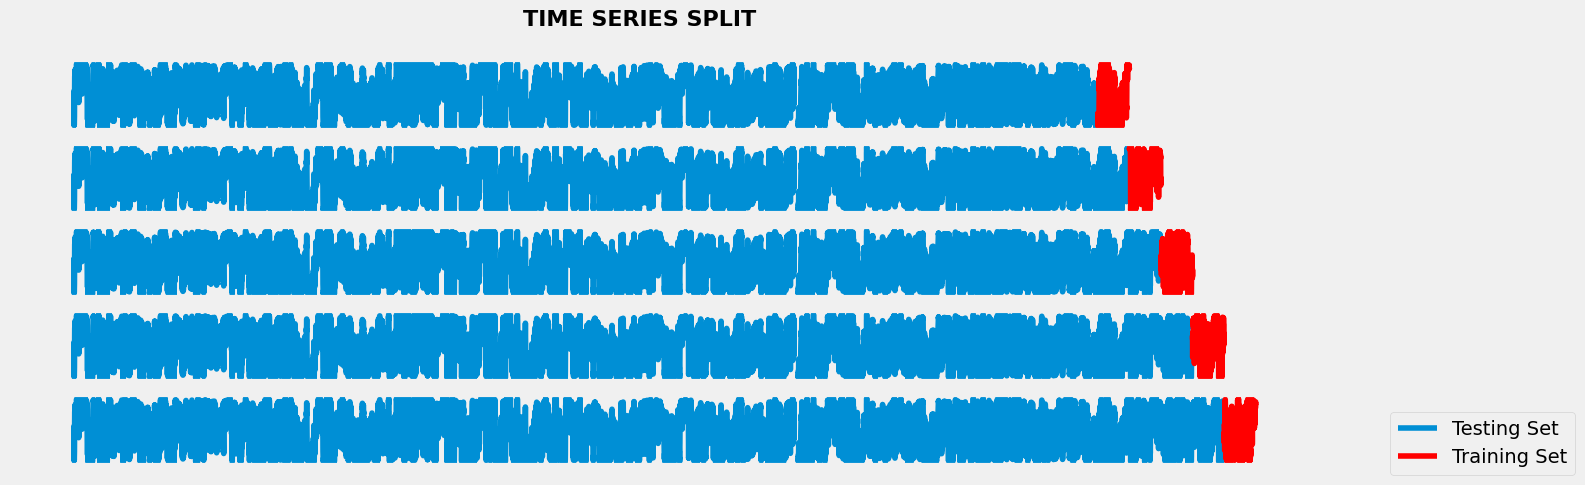

In [130]:
tss_visual(df_tss)

In [149]:
df_met = load_data('merged_file') # met = metrics
df_met.head()

,TIMESTAMP,POWER,FORECAST
0,20180201 01:00,0.876351,0.902948
1,20180201 02:00,0.921515,0.901904
2,20180201 03:00,0.895380,0.877563
3,20180201 04:00,0.898016,0.868336
4,20180201 05:00,0.862974,0.873988


In [150]:
def met_graph(df_orig):
    df = df_orig.copy()
    df['TIMESTAMP'] = pd.to_datetime(df.TIMESTAMP)
    df['DATE'] = df['TIMESTAMP'].dt.date.astype('string')
    power= df.POWER
    pred = df.FORECAST
    
    df['RMSE'] = np.sqrt(((power - pred)**2).expanding().mean())
    df['MAE'] = np.absolute(power-pred).expanding().mean()
    df['BIAS'] = (power-pred).expanding().mean()
    
    return df

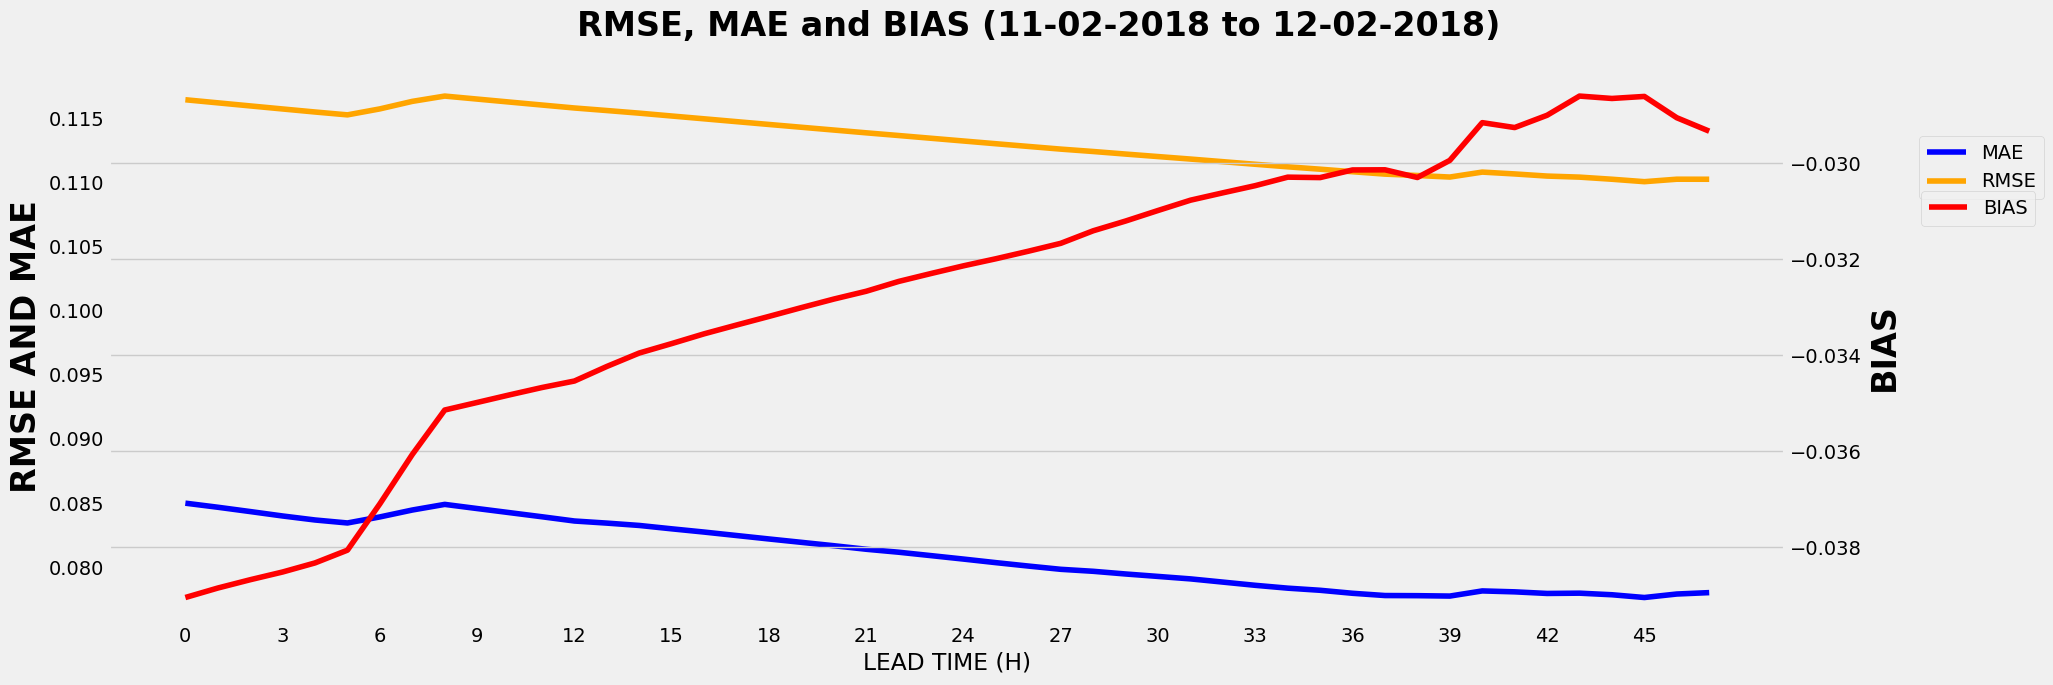

In [140]:
met = met_graph(df_met)
met['TIMESTAMP'] = pd.to_datetime(met.TIMESTAMP)
met['DATE'] = met['TIMESTAMP'].dt.date.astype('string')
met['HOUR'] = met['TIMESTAMP'].dt.hour.astype('int')
date_filter = (met['DATE'] == '2018-02-11') | (met['DATE'] == '2018-02-12')
met = met[date_filter]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.lineplot(x= 'TIMESTAMP',y='MAE', data=met, label = 'MAE', ax= ax1, color = 'blue')
sns.lineplot(x= 'TIMESTAMP',y='RMSE', data=met, label = 'RMSE', ax= ax1, color = 'orange')
sns.lineplot(x= 'TIMESTAMP',y='BIAS', data=met, label = 'BIAS', ax= ax2, color = 'red')

ax1.set_xlabel('LEAD TIME (H)')
ax1.set_ylabel('RMSE AND MAE', fontdict = font)
ax1.grid(False)
ax1.legend(bbox_to_anchor= (1.16,0.90))
ax2.legend(bbox_to_anchor= (1.155,0.80))
ax2.set_ylabel('BIAS', fontdict = font)

plt.suptitle('RMSE, MAE and BIAS (11-02-2018 to 12-02-2018)', fontsize = 24, fontweight = 'bold')
plt.xticks(met['TIMESTAMP'][:48],[i if i in np.arange(0,48,3) else '' for i in range(48)])
plt.tight_layout()
# plt.savefig('metrics_daily.png',bbox_inches='tight');

In [142]:
met1 = met_graph(df_met)
met1.head()

,TIMESTAMP,POWER,FORECAST,DATE,RMSE,MAE,BIAS
0,2018-02-01 01:00:00,0.876351,0.902948,2018-02-01,0.026597,0.026597,-0.026597
1,2018-02-01 02:00:00,0.921515,0.901904,2018-02-01,0.023367,0.023104,-0.003493
2,2018-02-01 03:00:00,0.895380,0.877563,2018-02-01,0.021675,0.021342,0.003610
3,2018-02-01 04:00:00,0.898016,0.868336,2018-02-01,0.023929,0.023426,0.010128
4,2018-02-01 05:00:00,0.862974,0.873988,2018-02-01,0.021962,0.020944,0.005899


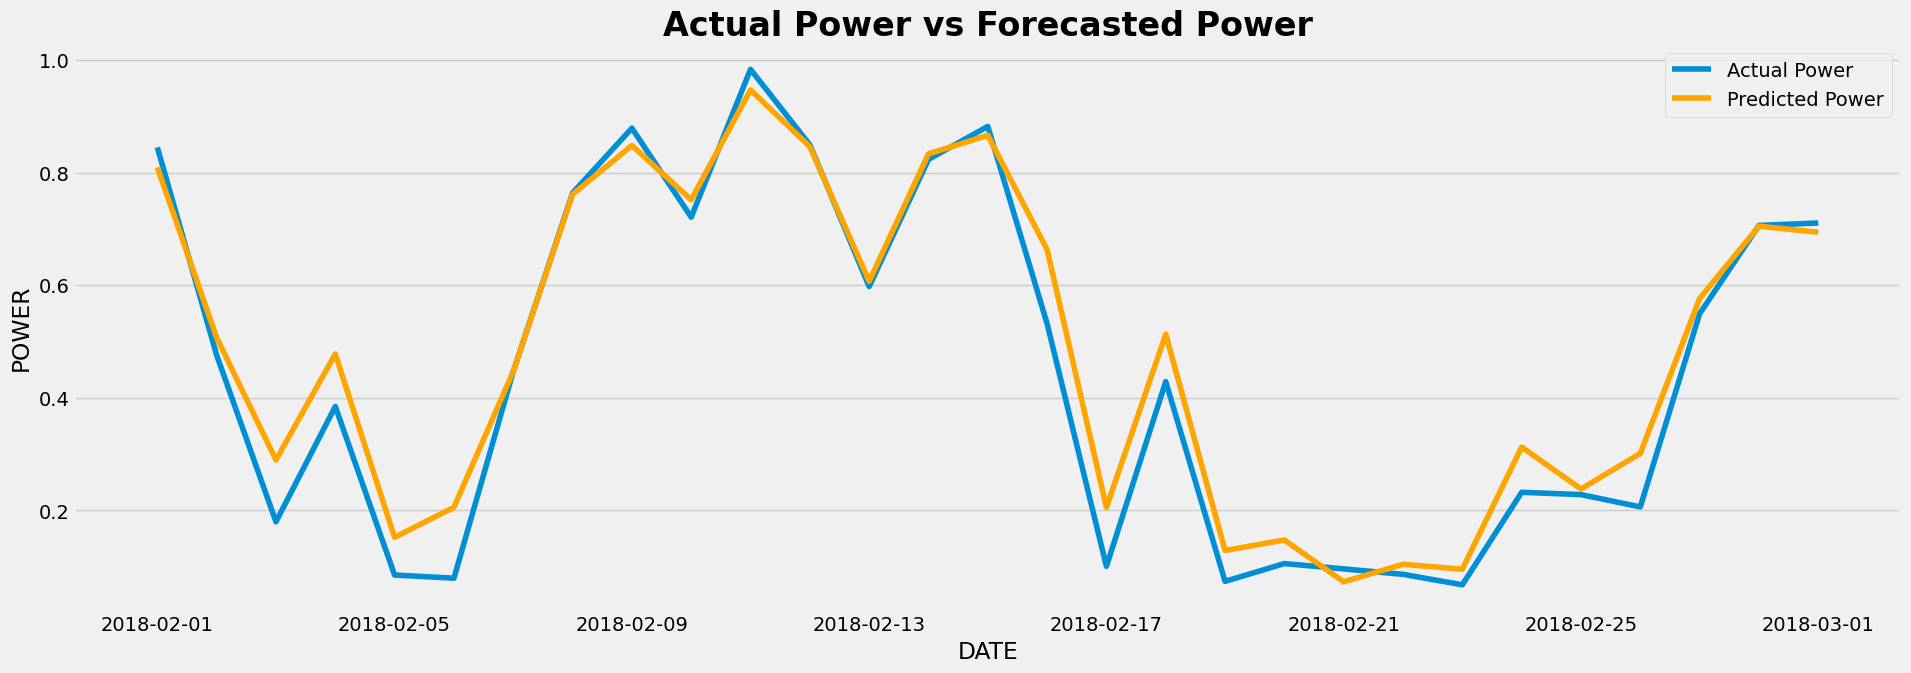

In [145]:
df_group = met1.groupby('DATE')[['POWER','FORECAST']].mean().reset_index()

sns.lineplot(x= df_group.DATE, y= 'POWER',data = df_group, label='Actual Power')
sns.lineplot(x= df_group.DATE, y= 'FORECAST', data = df_group, label='Predicted Power', color = 'orange')

plt.grid(False, axis = 'x')
plt.title('Actual Power vs Forecasted Power', fontsize = 24, fontweight = 'bold')
plt.xticks(df_group.DATE,[df_group['DATE'][i] if i in range(0,29,4) else '' for i in range(29)])
plt.savefig('actualvsforecasted.png',bbox_inches='tight');

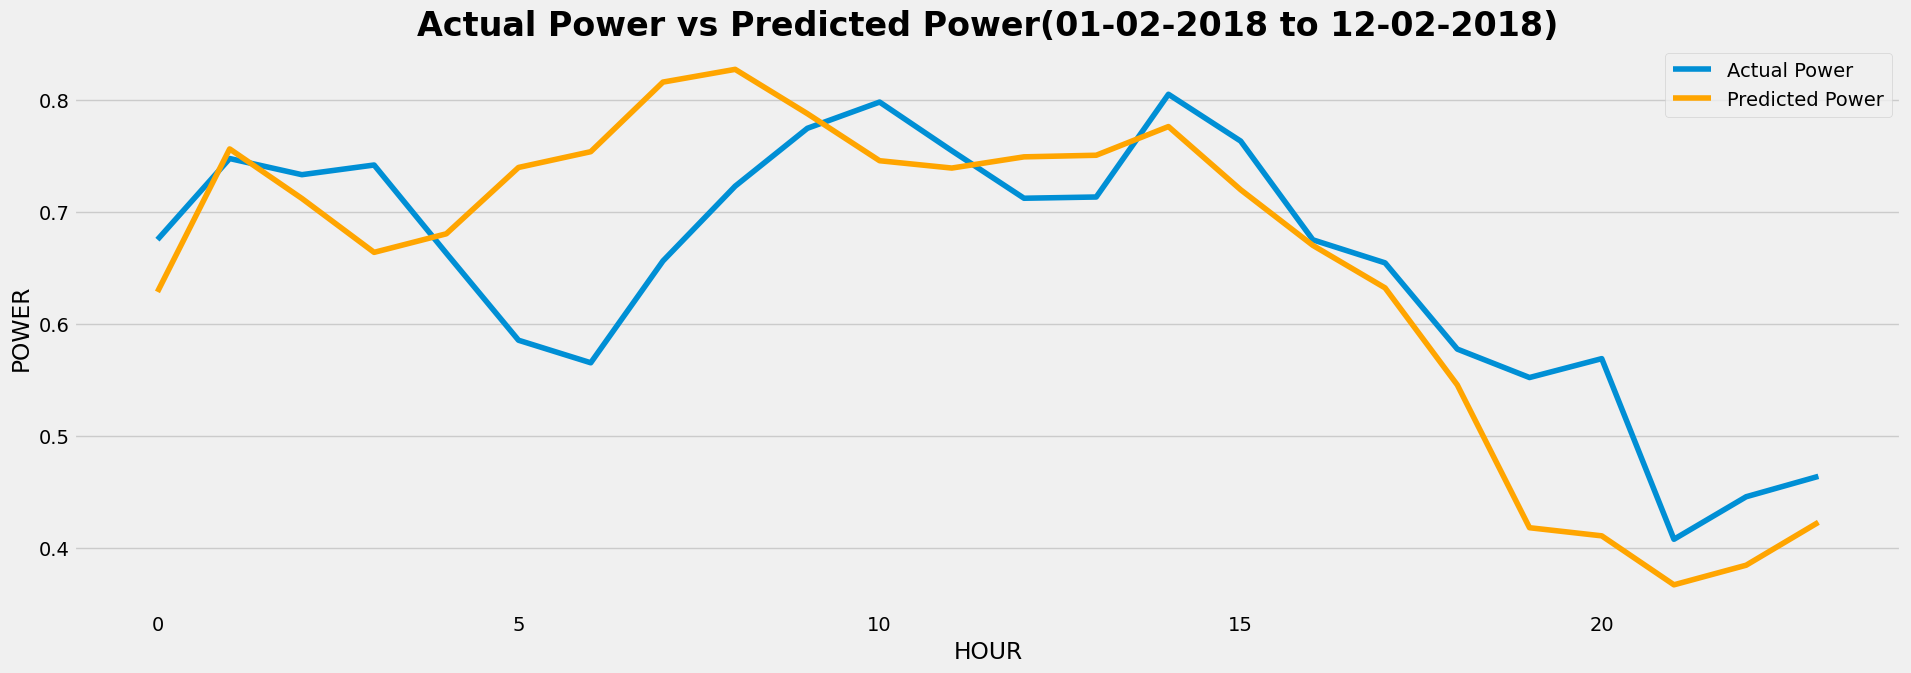

In [154]:
met2 = met_graph(df_met)
met2['HOUR'] = met2['TIMESTAMP'].dt.hour.astype('int')
new_filter = (met2['DATE'] == '2018-02-01') | (met2['DATE'] == '2018-02-02')
met2 = met2[new_filter]
sns.lineplot(x='HOUR', y= 'POWER', data=met2, label='Actual Power', errorbar=('ci',0))
sns.lineplot(x='HOUR', y= 'FORECAST', data=met2, label='Predicted Power', color='orange', errorbar=('ci',0));
plt.grid(False, axis= 'x')
plt.title('Actual Power vs Predicted Power(01-02-2018 to 12-02-2018)', fontsize = 24, fontweight = 'bold');
plt.savefig('actualvsforecasted_hourly.png',bbox_inches='tight');